In [35]:
import sys
import os
%cd "/content"

if os.path.exists("/content/Dragbuilduppy"):
  print("Found git Dragbuildup localy, will attempt pulling updates!")
  %cd "/content/Dragbuilduppy"
  !git pull
  %cd ..
else:
  print("git Dragbuildup not found, cloning it!")
  !git clone https://github.com/Danny2two/Dragbuilduppy.git

print(sys.path)
found = False
for i in sys.path:
  if i == '/content/Dragbuilduppy':
    print("Found Drag Librarys in path")
    found = True
if not found:
  print("Drag Librarys not found, Adding librarys to PATH")
  sys.path.insert(0,'/content/Dragbuilduppy')

try:
  import matplotlib.pyplot as plt
  print("Matplotlib Installed already!")
except ImportError as e:
  print("Matplotlib not found! Installing")
  %pip install matplotlib

%cd /content/Dragbuilduppy

/content
Found git Dragbuildup localy, will attempt pulling updates!
/content/Dragbuilduppy
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (5/5), 150.67 KiB | 2.84 MiB/s, done.
From https://github.com/Danny2two/Dragbuilduppy
   1925819..4a4abfe  main       -> origin/main
Updating 1925819..4a4abfe
Fast-forward
 JupyterNotebookArchive/Aere261ProjectE.ipynb | 459 +++++++++++++++++++++++++++++++++++++++++++++++
 craft.py                                     |   2 +-
 2 files changed, 460 insertions(+), 1 deletion(-)
 create mode 100644 JupyterNotebookArchive/Aere261ProjectE.ipynb
/content
['/content/Dragbuilduppy', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3

Everything above this is just setting up the VM with my Code, It shouldnt need to be run frequently, only when I update the background code. Or when the Compute engine is refreshed

Below, we are using my Librarys to Instantiate a new "Craft" called OppaStoppa, then we are setting its atmosphere conditions to match our expected mission conditions as well as setting the weight of the aircraft.

Then we Instantiate new "Draggy Components" these are the things that will be taken into the CD0 buildup.

Then we call compute() on all of the components to do the requred math for drag buildup.

Then we do some additional math for estimating Power and thrust requred, Vstall and CL.

In [36]:
import math
import matplotlib.pyplot as plt
import numpy as npy
from craft import *
import Components
from Drag import *
from StFl import *

"""
Defining our aircraft, and the properties of the atmosphere at the desired alt
"""
OppaStoppa = Craft("OpptaStoppa")
OppaStoppa.Atmosphere = Atmosphere(300,286.21, 9.77774,1.19,76)
atmo = OppaStoppa.Atmosphere
OppaStoppa.weight_empty = 4450 * 9.81
OppaStoppa.weight_takeoff = 5225 * 9.81


"""Defining the draggy components of our craft"""
MainWing = Wing3d("Oppa Main Wing","NACA 4312",34,25.26,10,1.76,-4,17,0.12,0.3,6.56,atmo)
MainFuselage = Fuselage("Oppa Fuselage",7.51,8.11,5.24,1.00,1.0,MainWing.Area,atmo)
HorizontalTail = Wing3d("HT","NACA 0012",26.57,4.58,2.44,0.915,0,15,0.12,0.3,0.12,atmo)
VerticalTail = Wing3d("VT","NACA 0012",26.57,4.58/2,2.44/2,0.915,0,15,0.12,0.3,0,atmo)
TailGear = FixedGear("Tail Gear",0.25,0.196129,MainWing.Area,1.2,atmo)

"""Defining our engines"""
WilliamsFJ33 = Engine("Willams FJ33",13.77,0,8210,0,0.9)
OppaStoppa.powertrain = [WilliamsFJ33,WilliamsFJ33]

OppaStoppa.dragcomponents = [MainWing,MainFuselage,HorizontalTail,VerticalTail,TailGear]

OppaStoppa.compute_components()
#OppaStoppa.print_stats_components() #Prints Details About overall C_d0 Calculation
print("Total CD0: " + str(OppaStoppa.Cd0))

k = calc_K_value(MainWing.OswaldE,MainWing.AR)
q = calc_dynpressure(OppaStoppa.Atmosphere.Density,OppaStoppa.Atmosphere.Vinfinity)
vstall = calc_Vstall(OppaStoppa.Atmosphere.Density,OppaStoppa.weight_takeoff,MainWing.Area,1.3858)

#Find various cl/cd ratios
clcdmax = calc_CL_CDmax(k,OppaStoppa.Cd0)
clcd2max = calc_CL_CDmaxRangeJet(k,OppaStoppa.Cd0)
print("CL/CD max: " + str(clcdmax))
print("CL^0.5/CD max:" + str(clcd2max))

#Calcualte endurance and range
#convert TSFC to WSFC? g/kN/s -> N_f/s/N_t
t1 = WilliamsFJ33.TSFC / 1000 #-> kg/s/kN
t2 = t1/1000 #-> kg/s/N
t3 = t2 * 9.81 #-> N/s/N N, weight of fuel burned / seconds / Newtons of thrust

maxrendurance = calc_endurance_turbojet(t3,clcdmax,OppaStoppa.weight_takeoff,OppaStoppa.weight_empty)
maxrange = calc_max_range_jet(atmo.Density,MainWing.Area,t3,clcd2max,OppaStoppa.weight_takeoff,OppaStoppa.weight_empty)
vinfMR = calc_Vinf_MaxJetRange(atmo.Density,OppaStoppa.weight_takeoff,MainWing.Area,OppaStoppa.Cd0,k)
vinfME = calc_Vinf_MaxJetEndurance(atmo.Density,OppaStoppa.weight_takeoff,MainWing.Area,OppaStoppa.Cd0,k)

print("Power Req: " + str(calc_PowerReq(OppaStoppa.Atmosphere.Density,OppaStoppa.Atmosphere.Vinfinity,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_takeoff)) + " Watts")
print("Thrust req (takeoff): " + str(calc_ThrustReq(q,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_takeoff)) + " Newtons")
print("Thrust req (empty): " + str(calc_ThrustReq(q,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_empty)) + " Newtons")
print("V Stall: " + str(vstall)+ " m/s")
estCL = calc_req_CL(OppaStoppa.weight_takeoff,q,MainWing.Area)
print("Estimated CL for routine flight: " + str(estCL))

#print("Max Endurance:" + str(maxrendurance) + " seconds")
print("Max Endurance:" + str(maxrendurance/60/60) + " Hours")
print("-at Vinf: " + str(vinfME))
#print("Max Range:" + str(maxrange) + " meters")
print("Max Range:" + str(maxrange/1000) + " km")
print("-at Vinf: " + str(vinfMR))




Total CD0: 0.027668085218920113
CL/CD max: 9.876739965007307
CL^0.5/CD max:15.226959938228607
Power Req: 395594.5297896376 Watts
Thrust req (takeoff): 5205.1911814426 Newtons
Thrust req (empty): 4435.268952083525 Newtons
V Stall: 49.608056915741194 m/s
Estimated CL for routine flight: 0.5904427654297123
Max Endurance:3.260771596550422 Hours
-at Vinf: 78.99345967792041
Max Range:1015.5703051218829 km
-at Vinf: 103.96123947532162


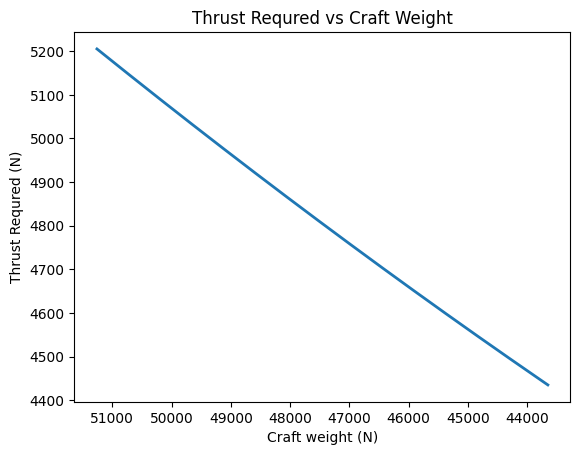

In [37]:
#Matplot stuff

#Plot Thrust required vs Weight (Boring chart lol)
xarr = npy.linspace(OppaStoppa.weight_takeoff,OppaStoppa.weight_empty,200)
y = []
index = 0
for num in xarr:
  y.append(calc_ThrustReq(q,MainWing.Area,OppaStoppa.Cd0,k,xarr[index]))
  #print(y[index])
  index += 1


fig, ax = plt.subplots()
ax.plot(xarr,y,linewidth=2)
ax.set(xlabel='Craft weight (N)', ylabel='Thrust Requred (N)',
       title='Thrust Requred vs Craft Weight')

plt.gca().invert_xaxis()
plt.show()

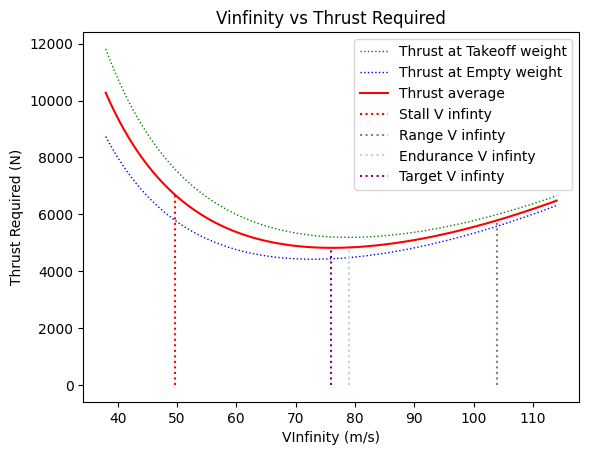

In [38]:
#Plot Thrust requred vs V_inf
vinfT = OppaStoppa.Atmosphere.Vinfinity
dens = OppaStoppa.Atmosphere.Density
Vinfarr = npy.linspace(vinfT - (vinfT/2),vinfT + (vinfT/2),100)

ytakeoff = []
yempty = []
yave = []
index = 0
for i in Vinfarr:
  q = calc_dynpressure(dens,i)
  ytakeoff.append(calc_ThrustReq(q,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_takeoff))
  yempty.append(calc_ThrustReq(q,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_empty))
  yave.append((yempty[index] + ytakeoff[index])/2)

  index +=1

fig, ThrVinf = plt.subplots()
ThrVinf.plot(Vinfarr,ytakeoff,":g",linewidth=1,label="Thrust at Takeoff weight")
ThrVinf.plot(Vinfarr,yempty,":b",linewidth=1,label="Thrust at Empty weight")
ThrVinf.plot(Vinfarr,yave,"r",label="Thrust average")

#find closest value in vinf array to stall speed
minarr = npy.absolute(Vinfarr-vstall)
locationofvstall = minarr.argmin()
plt.vlines(vstall,0,yave[locationofvstall],colors="red",linestyles="dotted",label="Stall V infinty")

#Find closest value to vinf max range
minarr = npy.absolute(Vinfarr-vinfMR)
locationofvMR = minarr.argmin()
plt.vlines(vinfMR,0,yave[locationofvMR],colors="grey",linestyles="dotted",label="Range V infinty")

#Find closest value to vinf max endurance
minarr = npy.absolute(Vinfarr-vinfME)
locationofvME = minarr.argmin()
plt.vlines(vinfME,0,yave[locationofvME],colors="lightblue",linestyles="dotted",label="Endurance V infinty")


plt.vlines(vinfT,0,yave[int(len(Vinfarr)/2)],colors="purple",linestyles="dotted",label="Target V infinty")

plt.legend()
ThrVinf.set(xlabel='VInfinity (m/s)', ylabel='Thrust Required (N)',
       title='Vinfinity vs Thrust Required')

plt.savefig("VinfvsThrust.svg",format="svg",bbox_inches='tight')
plt.show()

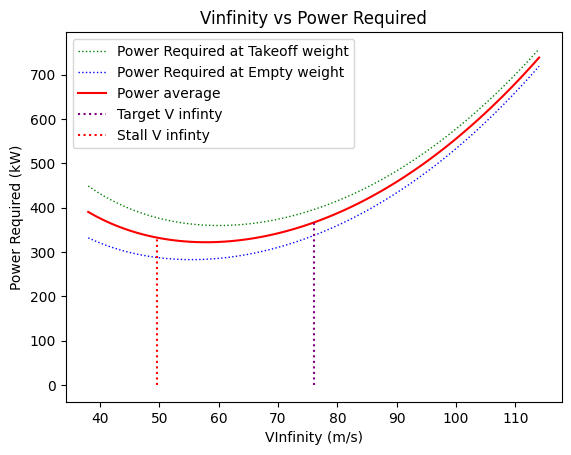

In [39]:
#Plot Power requred vs V_inf
vinfT = OppaStoppa.Atmosphere.Vinfinity
dens = OppaStoppa.Atmosphere.Density
Vinfarr = npy.linspace(vinfT - (vinfT/2),vinfT + (vinfT/2),100)

ytakeoff = []
yempty = []
yave = []
index = 0
for i in Vinfarr:
  #q = calc_dynpressure(dens,i)
  p = atmo.Density
  ytakeoff.append(calc_PowerReq(p,i,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_takeoff)/1000)
  yempty.append(calc_PowerReq(p,i,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_empty)/1000)
  yave.append((yempty[index] + ytakeoff[index])/2)

  index +=1

fig, ThrVinf = plt.subplots()
ThrVinf.plot(Vinfarr,ytakeoff,":g",linewidth=1,label="Power Required at Takeoff weight")
ThrVinf.plot(Vinfarr,yempty,":b",linewidth=1,label="Power Required at Empty weight")
ThrVinf.plot(Vinfarr,yave,"r",label="Power average")

#find closest value in vinf array to stall speed
minarr = npy.absolute(Vinfarr-vstall)
locationofvstall = minarr.argmin()

plt.vlines(vinfT,0,yave[int(len(Vinfarr)/2)],colors="purple",linestyles="dotted",label="Target V infinty")
plt.vlines(vstall,0,yave[locationofvstall],colors="red",linestyles="dotted",label="Stall V infinty")

plt.legend()
ThrVinf.set(xlabel='VInfinity (m/s)', ylabel='Power Required (kW)',
       title='Vinfinity vs Power Required')
plt.show()

Calculating fuel flow for a given thrust (PART E)

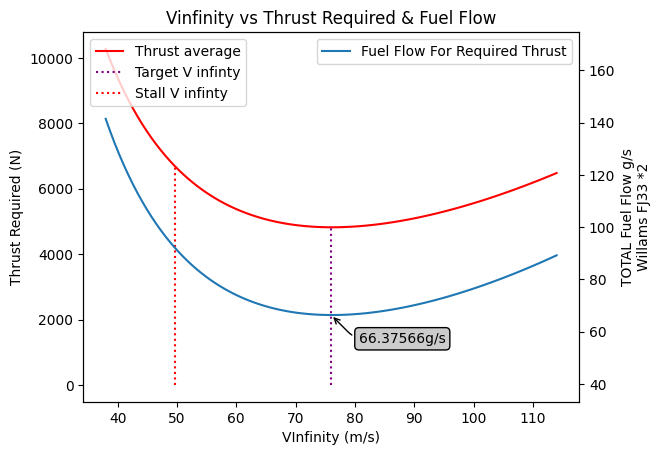

In [40]:
#Plot Thrust requred and FuelFlow vs V_inf
vinfT = OppaStoppa.Atmosphere.Vinfinity
dens = OppaStoppa.Atmosphere.Density
Vinfarr = npy.linspace(vinfT - (vinfT/2),vinfT + (vinfT/2),100)

ytakeoff = []
yempty = []
yave = []
index = 0
for i in Vinfarr:
  q = calc_dynpressure(dens,i)
  ytakeoff.append(calc_ThrustReq(q,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_takeoff))
  yempty.append(calc_ThrustReq(q,MainWing.Area,OppaStoppa.Cd0,k,OppaStoppa.weight_empty))
  yave.append((yempty[index] + ytakeoff[index])/2)

  index +=1

fig, ThrVinf = plt.subplots()
#ThrVinf.plot(Vinfarr,ytakeoff,":g",linewidth=1,label="Thrust at Takeoff weight")
#ThrVinf.plot(Vinfarr,yempty,":b",linewidth=1,label="Thrust at Empty weight")
ThrVinf.plot(Vinfarr,yave,"r",label="Thrust average")

fr = []
index = 0
for i in Vinfarr:
  fr.append(OppaStoppa.powertrain[0].calc_fuelrate_from_thrust(yave[index]))
  #print(fr[index])
  index += 1

enginestr = OppaStoppa.powertrain[0].Name + " *" + str(len(OppaStoppa.powertrain))
fuel = ThrVinf.twinx()
fuel.plot(Vinfarr, fr,label="Fuel Flow For Required Thrust")
fuel.set(xlabel='VInfinity (m/s)', ylabel='TOTAL Fuel Flow g/s\n' + enginestr)
fuel.set_ylim(min(fr)-(min(fr)/2),max(fr)+(min(fr)/2))
fuel.legend(loc="upper right")

#find closest value in vinf array to stall speed
minarr = npy.absolute(Vinfarr-vstall)
locationofvstall = minarr.argmin()

#Draw vertical lines
ThrVinf.vlines(vinfT,0,yave[int(len(Vinfarr)/2)],colors="purple",linestyles="dotted",label="Target V infinty")
ThrVinf.vlines(vstall,0,yave[locationofvstall],colors="red",linestyles="dotted",label="Stall V infinty")
ThrVinf.legend(loc="upper left")

#

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=-45,rad=10")

Fuelamnt = str(round(fr[int(len(Vinfarr)/2)],5)) + "g/s"
fuel.annotate(Fuelamnt,(vinfT,fr[int(len(Vinfarr)/2)]),arrowprops=arrowprops,bbox=bbox,xytext=(20,-20), textcoords='offset points')

ThrVinf.set(xlabel='VInfinity (m/s)', ylabel='Thrust Required (N)',
       title='Vinfinity vs Thrust Required & Fuel Flow')
plt.savefig("VinfVsThrust&FuelFlow.svg",format="svg",bbox_inches='tight')
plt.show()